## USA Rugby EDA
### on player availability, daily wellness, sonra

In [1]:
# EDA, manipuation, and cleaning packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model

# model evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# model optimization
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt


### Import Data

In [2]:
avail = pd.read_csv('/Users/linanguyen/Desktop/Capstone/daily availability pivot.csv', error_bad_lines = False, header = 1)

In [3]:
avail

,Date,Full,Modified,No Training,Grand Total
0,11/1/21,18,NaN,NaN,18
1,11/2/21,22,NaN,NaN,22
2,11/3/21,18,NaN,NaN,18
3,11/4/21,22,NaN,NaN,22
4,11/5/21,22,NaN,NaN,22
...,...,...,...,...,...
96,30/10/2021,4,NaN,NaN,4
97,30/11/2021,17,NaN,1.0,18
98,30/12/2021,17,1.0,1.0,19
99,31/03/2022,18,NaN,1.0,19


In [4]:
well = pd.read_csv('/Users/linanguyen/Desktop/Capstone/Daily wellness pivot.csv')

In [5]:
well.columns

Index(['Date', 'AVERAGE of Wellness Score'], dtype='object')

In [6]:
stat = pd.read_csv('/Users/linanguyen/Desktop/Capstone/statsports sonra excel report - statsports sonra excel report.csv')

/Users/linanguyen/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
stat.columns

Index(['Date', 'About', 'Player', 'DOB', 'Age', 'Position', 'Month',
       'Year Text', 'Year Number', 'Season',
       ...
       'HSR Monthly Load', 'HSR AC', 'Running Distance AC',
       'Z6 Distance 7 Day Load', 'Z6 Distance 28 Day Load',
       'Sprint Distance Monthly', 'Z6 Distance AC', 'HI A+D 7 Day Load',
       'HI A+D 28 Day Load', 'HI A+D AC'],
      dtype='object', length=318)

### Cleaning Data

In [8]:
# wellness data
# we will only keep columns Date, and Wellness Score, and find team average of wellness score by date
# for reference, wellness score tells us the phyisical and emotional state of an athelte that day, out of 42
# wellsmall = well[['Date', 'Wellness Score']]

In [9]:
# convert Date to datetime format
well['Date'] = pd.to_datetime(well['Date'])
well = well.rename(columns = {"AVERAGE of Wellness Score": "AvgWellScore"})

In [10]:
well.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          228 non-null    datetime64[ns]
 1   AvgWellScore  228 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.7 KB


In [11]:
# grouping data by date column
# wellsmall = wellsmall.groupby('Date', as_index = False)['Wellness Score'].mean()
# wellsmall

In [12]:
# look at distribution. Wellness score is out of 42
well.describe()

,AvgWellScore
count,228.000000
mean,26.442217
std,2.441921
min,16.500000
25%,25.280952
50%,26.639610
75%,28.076299
max,32.666667


In [13]:
# check for null values
well['AvgWellScore'].isna().sum()

0

In [14]:
avail

,Date,Full,Modified,No Training,Grand Total
0,11/1/21,18,NaN,NaN,18
1,11/2/21,22,NaN,NaN,22
2,11/3/21,18,NaN,NaN,18
3,11/4/21,22,NaN,NaN,22
4,11/5/21,22,NaN,NaN,22
...,...,...,...,...,...
96,30/10/2021,4,NaN,NaN,4
97,30/11/2021,17,NaN,1.0,18
98,30/12/2021,17,1.0,1.0,19
99,31/03/2022,18,NaN,1.0,19


In [15]:
# Daily Availability
# Daily Avaialbility determined by Field Status Player Cards
# Full = 2, Modified = 1, No Training = 0
# make dataframe of Date, count of full, count of modified, count of no training, % of full availability
# replace NaN with 0
avail = avail.fillna(0)

In [16]:
# create a column of full availability percentage
avail['Full%'] = avail['Full']/avail['Grand Total'] 

In [17]:
# convert Date to datetime format
avail['Date'] = pd.to_datetime(avail['Date'])
avail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         101 non-null    datetime64[ns]
 1   Full         101 non-null    int64         
 2   Modified     101 non-null    float64       
 3   No Training  101 non-null    float64       
 4   Grand Total  101 non-null    int64         
 5   Full%        101 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 4.9 KB


In [18]:
avail.describe()

,Full,Modified,No Training,Grand Total,Full%
count,101.000000,101.000000,101.000000,101.000000,101.000000
mean,17.564356,0.217822,0.683168,18.465347,0.953008
std,3.980994,0.460521,0.564459,4.097717,0.044556
min,3.000000,0.000000,0.000000,3.000000,0.842105
25%,17.000000,0.000000,0.000000,18.000000,0.944444
50%,18.000000,0.000000,1.000000,19.000000,0.947368
75%,18.000000,0.000000,1.000000,19.000000,1.000000
max,36.000000,2.000000,2.000000,38.000000,1.000000


In [19]:
# SONRA Stat
# Running load will only be examined because that's what is mainly looked at for team field sports
statsmall = stat[['Date', 'Drill Running Load', 'Total Weekly Running Load', 'Running 7 Day Load', 'Running 28 Day Load']]

In [20]:
# drop rows with NaN because every practice, every player produces 6 rows of data, with 5 rows empty in load columns
# finding team averages by date
statsmall = statsmall.dropna()
statsmall = statsmall.groupby('Date', as_index = False)[['Drill Running Load', 'Total Weekly Running Load', 'Running 7 Day Load', 'Running 28 Day Load']].mean()

In [21]:
# convert Date to datetime format
statsmall['Date'] = pd.to_datetime(statsmall['Date'])

In [22]:
statsmall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 124
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       125 non-null    datetime64[ns]
 1   Drill Running Load         125 non-null    float64       
 2   Total Weekly Running Load  125 non-null    float64       
 3   Running 7 Day Load         125 non-null    float64       
 4   Running 28 Day Load        125 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.9 KB


In [23]:
statsmall.describe()

,Drill Running Load,Total Weekly Running Load,Running 7 Day Load,Running 28 Day Load
count,125.000000,125.000000,125.000000,125.000000
mean,42.457868,154.876862,1138.412635,1147.131374
std,16.908657,92.662664,303.019947,189.872993
min,12.400000,12.400000,529.764706,729.615385
25%,30.346154,79.230769,950.900000,1026.363636
50%,38.551724,133.941176,1141.217391,1151.648649
75%,51.366667,213.942308,1311.625000,1231.857143
max,95.384615,433.047619,2091.454545,1548.909091


In [24]:
statsmall

,Date,Drill Running Load,Total Weekly Running Load,Running 7 Day Load,Running 28 Day Load
0,2022-01-10,51.366667,78.366667,1093.466667,1191.200000
1,2022-01-11,21.214286,131.071429,1092.035714,1144.785714
2,2022-01-03,37.120000,50.040000,1391.440000,1334.280000
3,2022-01-04,30.346154,109.653846,1201.884615,1233.153846
4,2022-01-06,44.458333,189.208333,1124.666667,1235.916667
...,...,...,...,...,...
120,2022-05-10,50.823529,147.000000,1721.176471,1103.058824
121,2022-05-12,48.055556,186.888889,1641.944444,1111.666667
122,2022-05-05,48.500000,48.500000,886.000000,1059.444444
123,2022-05-06,52.111111,100.611111,1064.944444,1114.166667


In [25]:
avail

,Date,Full,Modified,No Training,Grand Total,Full%
0,2021-11-01,18,0.0,0.0,18,1.000000
1,2021-11-02,22,0.0,0.0,22,1.000000
2,2021-11-03,18,0.0,0.0,18,1.000000
3,2021-11-04,22,0.0,0.0,22,1.000000
4,2021-11-05,22,0.0,0.0,22,1.000000
...,...,...,...,...,...,...
96,2021-10-30,4,0.0,0.0,4,1.000000
97,2021-11-30,17,0.0,1.0,18,0.944444
98,2021-12-30,17,1.0,1.0,19,0.894737
99,2022-03-31,18,0.0,1.0,19,0.947368


In [26]:
# merge data by date
df = statsmall.merge(avail, how = 'left', on = 'Date')
df = df.merge(well, how = 'left', on = 'Date')

In [27]:
df

,Date,Drill Running Load,Total Weekly Running Load,Running 7 Day Load,Running 28 Day Load,Full,Modified,No Training,Grand Total,Full%,AvgWellScore
0,2022-01-10,51.366667,78.366667,1093.466667,1191.200000,18.0,0.0,1.0,19.0,0.947368,NaN
1,2022-01-11,21.214286,131.071429,1092.035714,1144.785714,18.0,0.0,1.0,19.0,0.947368,NaN
2,2022-01-03,37.120000,50.040000,1391.440000,1334.280000,17.0,1.0,1.0,19.0,0.894737,30.692308
3,2022-01-04,30.346154,109.653846,1201.884615,1233.153846,17.0,1.0,1.0,19.0,0.894737,27.357143
4,2022-01-06,44.458333,189.208333,1124.666667,1235.916667,17.0,1.0,1.0,19.0,0.894737,29.000000
...,...,...,...,...,...,...,...,...,...,...,...
120,2022-05-10,50.823529,147.000000,1721.176471,1103.058824,17.0,1.0,1.0,19.0,0.894737,NaN
121,2022-05-12,48.055556,186.888889,1641.944444,1111.666667,17.0,1.0,1.0,19.0,0.894737,NaN
122,2022-05-05,48.500000,48.500000,886.000000,1059.444444,NaN,NaN,NaN,NaN,NaN,26.500000
123,2022-05-06,52.111111,100.611111,1064.944444,1114.166667,17.0,1.0,1.0,19.0,0.894737,NaN


In [28]:
df.describe()

,Drill Running Load,Total Weekly Running Load,Running 7 Day Load,Running 28 Day Load,Full,Modified,No Training,Grand Total,Full%,AvgWellScore
count,125.000000,125.000000,125.000000,125.000000,71.000000,71.000000,71.000000,71.000000,71.000000,90.000000
mean,42.457868,154.876862,1138.412635,1147.131374,18.323944,0.281690,0.774648,19.380282,0.945095,27.057544
std,16.908657,92.662664,303.019947,189.872993,2.649931,0.512225,0.565614,2.543149,0.046520,2.038818
min,12.400000,12.400000,529.764706,729.615385,15.000000,0.000000,0.000000,15.000000,0.842105,19.636364
25%,30.346154,79.230769,950.900000,1026.363636,17.000000,0.000000,0.000000,19.000000,0.897368,25.911765
50%,38.551724,133.941176,1141.217391,1151.648649,18.000000,0.000000,1.000000,19.000000,0.947368,27.000000
75%,51.366667,213.942308,1311.625000,1231.857143,18.000000,0.500000,1.000000,19.000000,1.000000,28.288462
max,95.384615,433.047619,2091.454545,1548.909091,36.000000,2.000000,2.000000,38.000000,1.000000,31.000000


In [29]:
# check for null values
df.isna().sum()

Date                          0
Drill Running Load            0
Total Weekly Running Load     0
Running 7 Day Load            0
Running 28 Day Load           0
Full                         54
Modified                     54
No Training                  54
Grand Total                  54
Full%                        54
AvgWellScore                 35
dtype: int64

<AxesSubplot:>

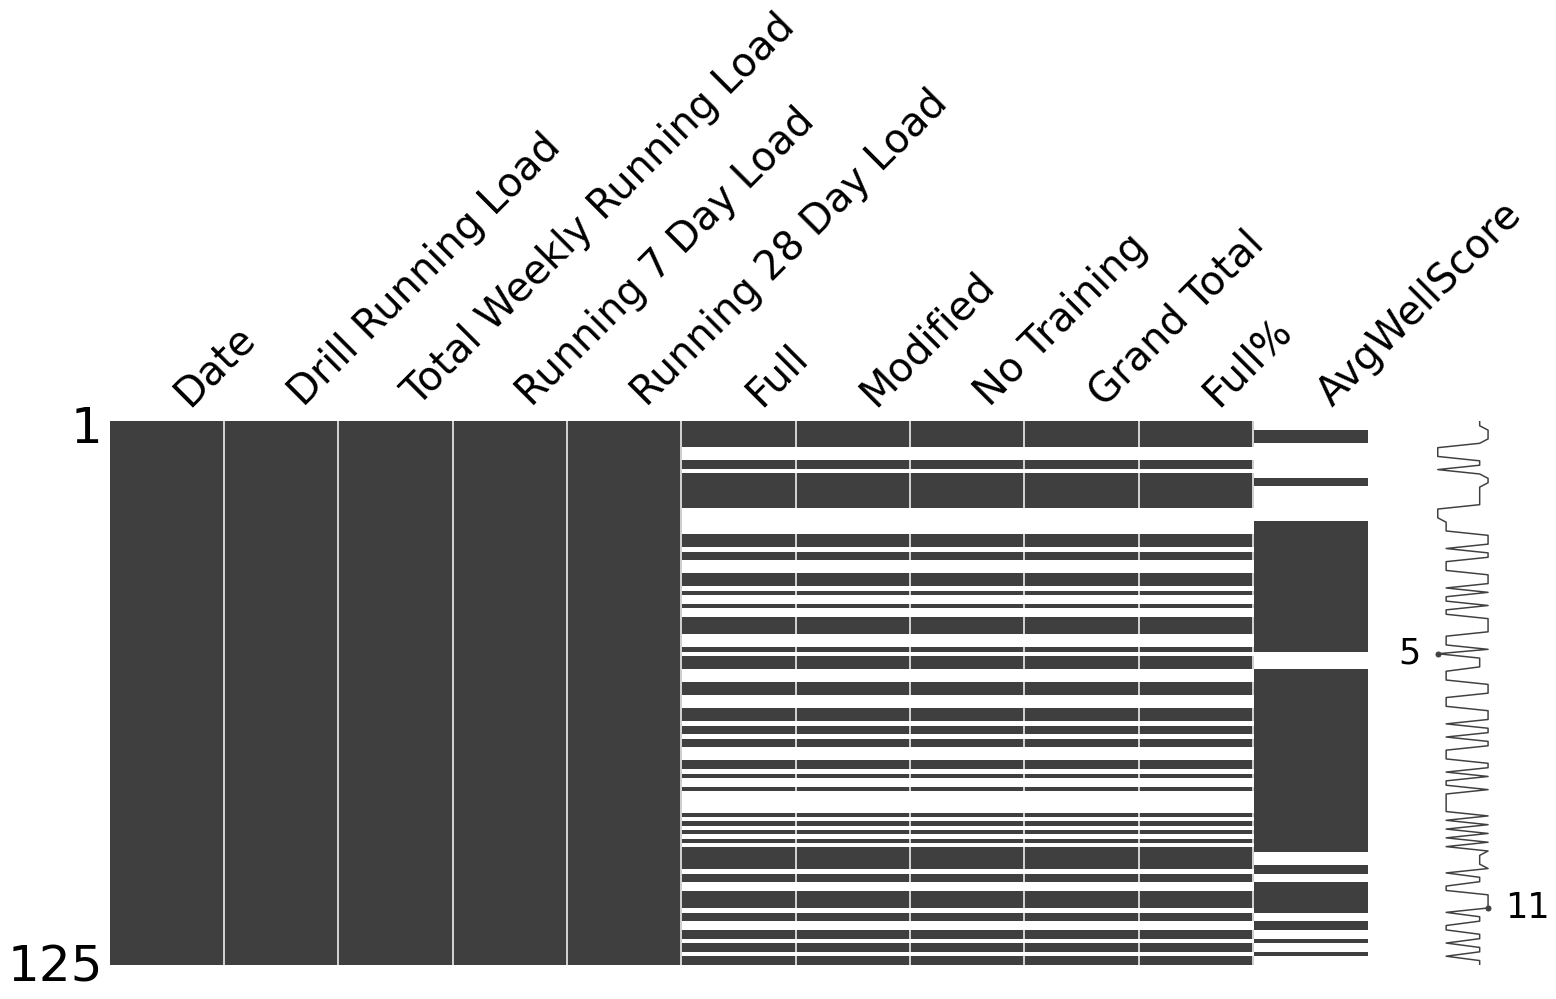

In [30]:
# visualize missing values
msno.matrix(df, fontsize = 40)

<AxesSubplot:>

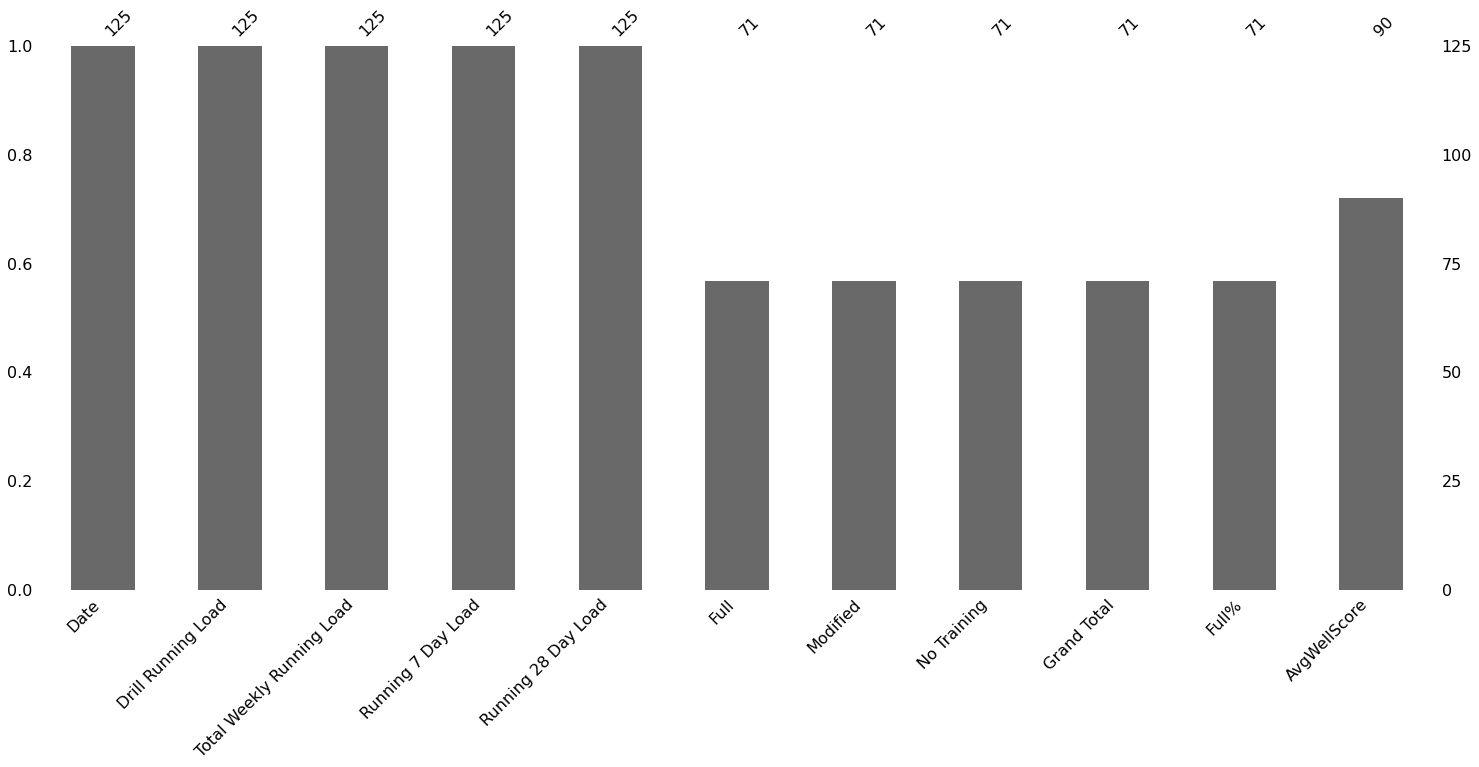

In [31]:
# barchart of missing data
msno.bar(df)

<AxesSubplot:>

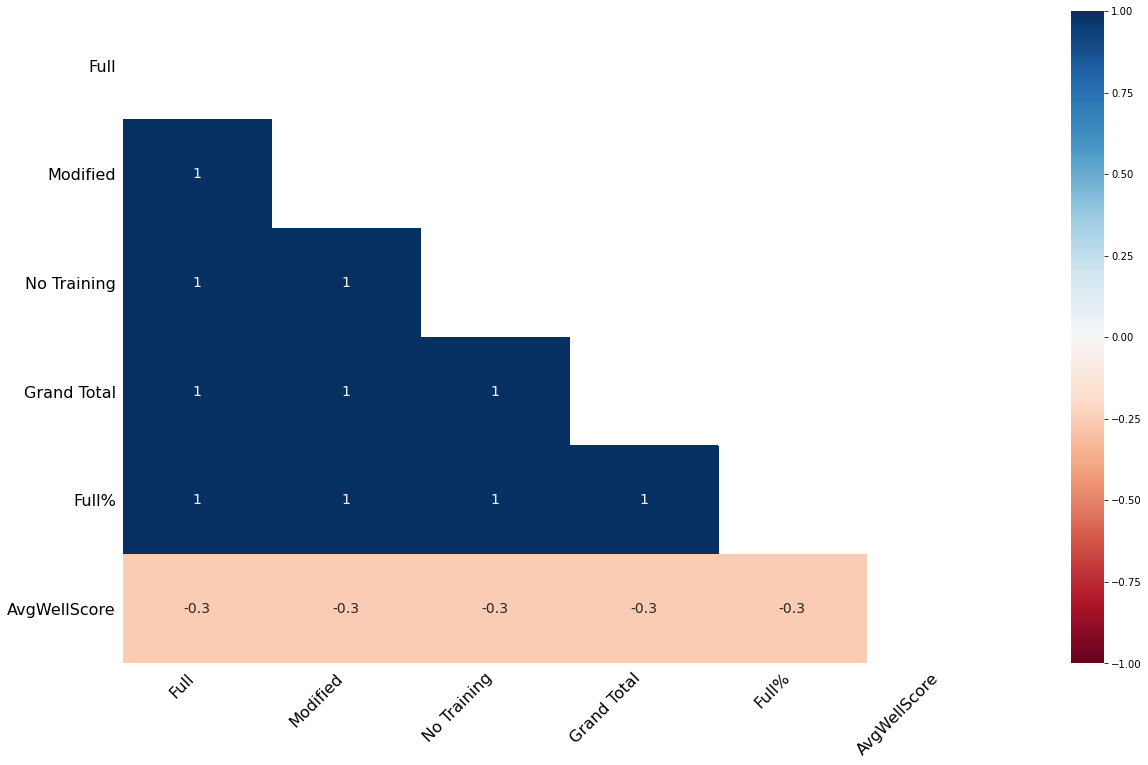

In [32]:
# visualize heatmape of how missing values are related
msno.heatmap(df)

<AxesSubplot:>

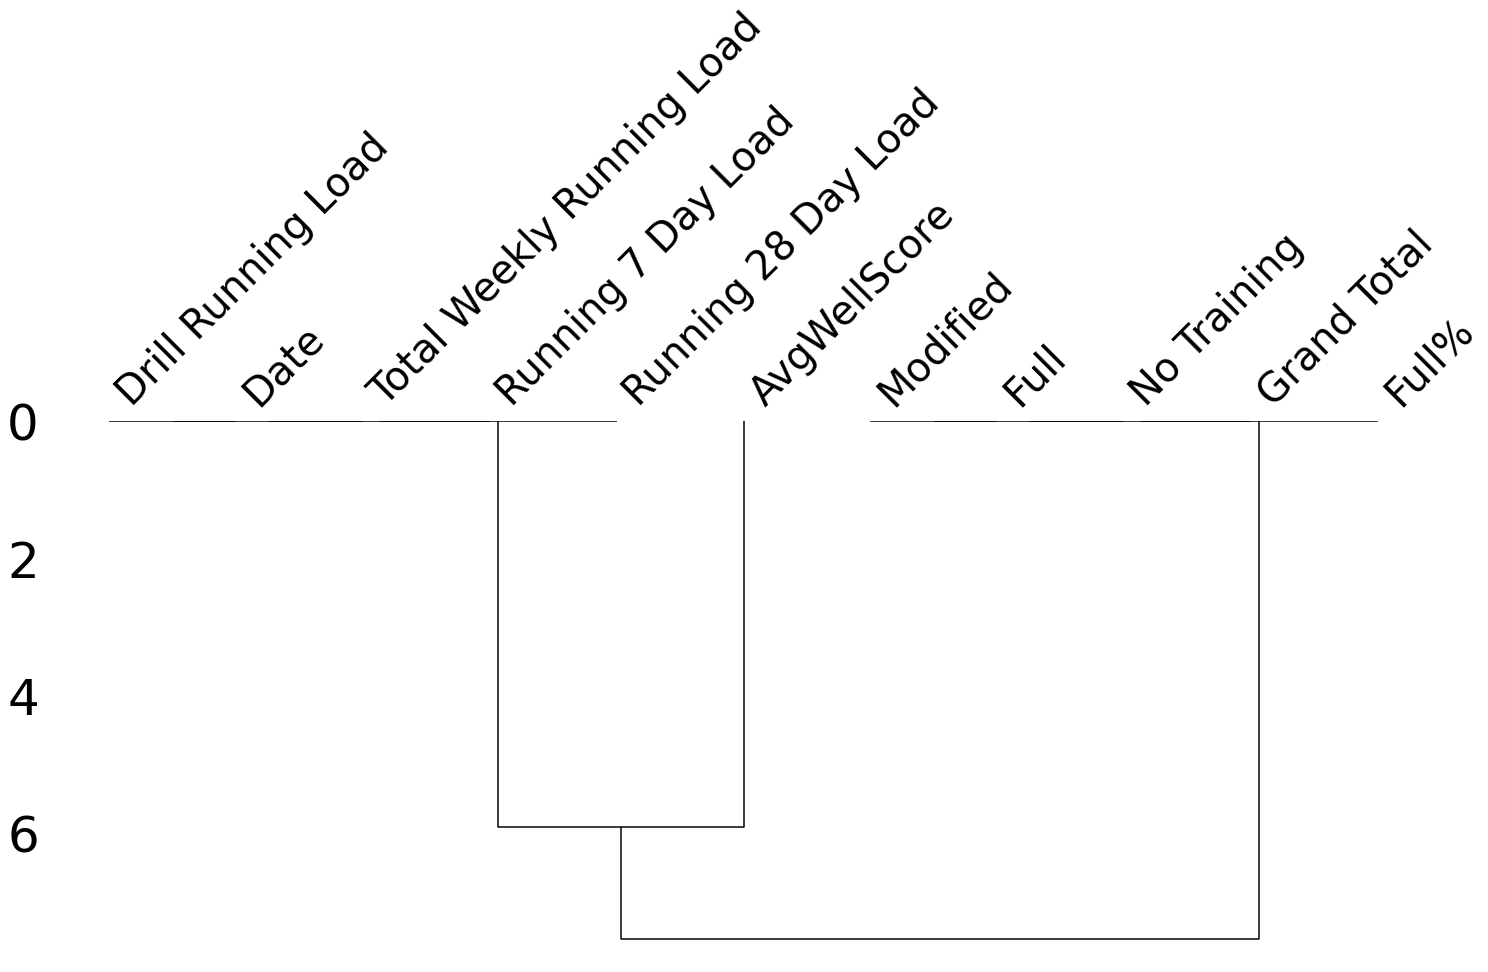

In [33]:
msno.dendrogram(df, fontsize = 40)

In [34]:
df1 = df.drop(['Date'], axis = 1)

In [35]:
# use iterativeImputer for availability because athletes that are injured will most likely still be injured the following practice
impute_it = IterativeImputer()
df1 = impute_it.fit_transform(df1)

In [36]:
df1 = pd.DataFrame(df1)

In [37]:
df1['Date'] = df['Date']

In [38]:
df1.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'Date'], dtype='object')

In [39]:
df.columns

Index(['Date', 'Drill Running Load', 'Total Weekly Running Load',
       'Running 7 Day Load', 'Running 28 Day Load', 'Full', 'Modified',
       'No Training', 'Grand Total', 'Full%', 'AvgWellScore'],
      dtype='object')

In [40]:
df1.columns = ['Drill Running Load', 'Total Weekly Running Load',
       'Running 7 Day Load', 'Running 28 Day Load', 'Full', 'Modified',
       'No Training', 'Grand Total', 'Full%', 'AvgWellScore', 'Date']

In [41]:
df1

,Drill Running Load,Total Weekly Running Load,Running 7 Day Load,Running 28 Day Load,Full,Modified,No Training,Grand Total,Full%,AvgWellScore,Date
0,51.366667,78.366667,1093.466667,1191.200000,18.000000,0.00000,1.000000,19.000000,0.947368,27.258871,2022-01-10
1,21.214286,131.071429,1092.035714,1144.785714,18.000000,0.00000,1.000000,19.000000,0.947368,27.063021,2022-01-11
2,37.120000,50.040000,1391.440000,1334.280000,17.000000,1.00000,1.000000,19.000000,0.894737,30.692308,2022-01-03
3,30.346154,109.653846,1201.884615,1233.153846,17.000000,1.00000,1.000000,19.000000,0.894737,27.357143,2022-01-04
4,44.458333,189.208333,1124.666667,1235.916667,17.000000,1.00000,1.000000,19.000000,0.894737,29.000000,2022-01-06
...,...,...,...,...,...,...,...,...,...,...,...
120,50.823529,147.000000,1721.176471,1103.058824,17.000000,1.00000,1.000000,19.000000,0.894737,27.547084,2022-05-10
121,48.055556,186.888889,1641.944444,1111.666667,17.000000,1.00000,1.000000,19.000000,0.894737,27.375687,2022-05-12
122,48.500000,48.500000,886.000000,1059.444444,18.323944,0.28169,0.774648,19.380282,0.947073,26.500000,2022-05-05
123,52.111111,100.611111,1064.944444,1114.166667,17.000000,1.00000,1.000000,19.000000,0.894737,27.103787,2022-05-06


### EDA

In [42]:
# create new data frame for eda, and add month column
eda = df1
eda['month'] = pd.DatetimeIndex(df1['Date']).month

In [43]:
avgMFull = eda.groupby('month', as_index = False)['Full%'].mean()
avgMFull['Full%'] = avgMFull['Full%']*100
avgMFull

,month,Full%
0,1,93.536946
1,2,94.238660
2,3,94.467441
3,4,91.293634
4,5,93.106952
5,10,97.965437
6,11,98.076407
7,12,93.286265


In [44]:
# avgMFull = avgMFull.reindex([8,9,10,11,0,1,2,3,4,5,6,7])
# avgMFull
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Oct', 'Nov', 'Dec']
month = pd.DataFrame(month)
avgMFull = pd.concat([avgMFull, month], axis = 1)
avgMFull = avgMFull.drop(['month'], axis = 1)

In [45]:
avgMFull = avgMFull.rename(columns = {'Full%': 'Full%', 0: 'Month'})

In [46]:
avgMFull

,Full%,Month
0,93.536946,Jan
1,94.238660,Feb
2,94.467441,Mar
3,91.293634,Apr
4,93.106952,May
5,97.965437,Oct
6,98.076407,Nov
7,93.286265,Dec


In [47]:
# need to fix order of months in the season from Oct 2021-May 2022 for all visuals


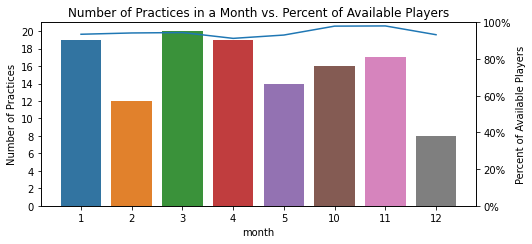

In [48]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

ax = sns.countplot(x = 'month', data = eda)
ax.yaxis.set_ticks(np.arange(0,21,2))
ax1 = ax.twinx()
ax2 = ax1.plot(avgMFull['Full%'])

ax1.set_ylim([0, 100])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# plt.legend([ax, ax2], ["Number of Practices", "Percent of Available Players"])
ax.set_ylabel("Number of Practices")
ax1.set_ylabel("Percent of Available Players")

plt.title("Number of Practices in a Month vs. Percent of Available Players")
plt.show()

In [49]:
avgMWell = eda.groupby('month', as_index = False)['AvgWellScore'].mean()
avgMWell

,month,AvgWellScore
0,1,27.303086
1,2,27.208019
2,3,26.905313
3,4,27.937898
4,5,26.196381
5,10,26.481840
6,11,27.300000
7,12,26.534033


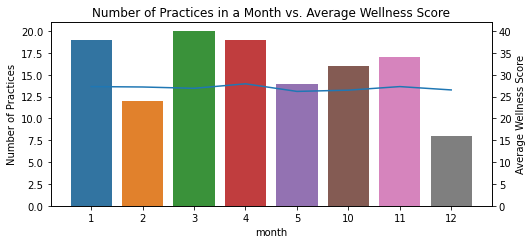

In [50]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

ax = sns.countplot(x = 'month', data = eda)
ax1 = ax.twinx()
ax2 = ax1.plot(avgMWell['AvgWellScore'])

ax1.set_ylim([0, 42])

# plt.legend([ax, ax2], ["Number of Practices", "Percent of Available Players"])
ax.set_ylabel("Number of Practices")
ax1.set_ylabel("Average Wellness Score")
plt.title("Number of Practices in a Month vs. Average Wellness Score")
plt.show()

In [51]:
avgMLoad = eda.groupby('month', as_index = False)['Drill Running Load'].mean()
avgMLoad

,month,Drill Running Load
0,1,33.826852
1,2,37.567342
2,3,46.191331
3,4,43.901601
4,5,46.670411
5,10,51.695627
6,11,40.726619
7,12,35.361228


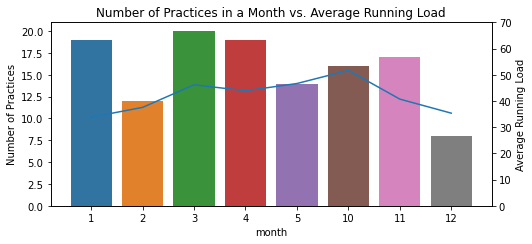

In [52]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

ax = sns.countplot(x = 'month', data = eda)
ax1 = ax.twinx()
ax2 = ax1.plot(avgMLoad['Drill Running Load'])

ax1.set_ylim([0,70])

# plt.legend([ax, ax2], ["Number of Practices", "Percent of Available Players"])
ax.set_ylabel("Number of Practices")
ax1.set_ylabel("Average Running Load")
plt.title("Number of Practices in a Month vs. Average Running Load")
plt.show()

In [53]:
totalMLoad = eda.groupby('month', as_index = False)['Drill Running Load'].sum()
totalMLoad['Full%'] = avgMFull['Full%']
totalMLoad

,month,Drill Running Load,Full%
0,1,642.710181,93.536946
1,2,450.808104,94.238660
2,3,923.826617,94.467441
3,4,834.130412,91.293634
4,5,653.385755,93.106952
5,10,827.130039,97.965437
6,11,692.352517,98.076407
7,12,282.889824,93.286265


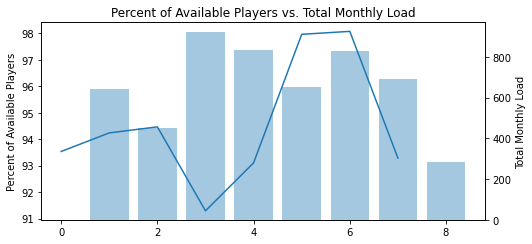

In [54]:
fig, ax1 = plt.subplots()
ax1.plot(totalMLoad['Full%'])
ax1t = ax1.twinx()

ax1t.bar(np.arange(1,9,1), totalMLoad['Drill Running Load'], alpha = 0.4)

ax1.set_ylabel("Percent of Available Players")
ax1t.set_ylabel("Total Monthly Load")
plt.title("Percent of Available Players vs. Total Monthly Load")
plt.show()

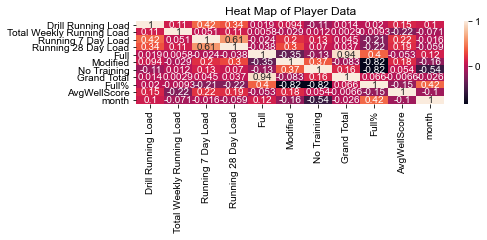

In [55]:
# view correlation
sns.heatmap(df1.corr(), annot = True)
sns.set(rc = {"figure.figsize":(20,20)})
plt.title('Heat Map of Player Data')
plt.show()

In [56]:
# grand total, away, full, modified, no training will be dropped - Full% represents this data 

### Data Preparation

In [57]:
df1.columns

Index(['Drill Running Load', 'Total Weekly Running Load', 'Running 7 Day Load',
       'Running 28 Day Load', 'Full', 'Modified', 'No Training', 'Grand Total',
       'Full%', 'AvgWellScore', 'Date', 'month'],
      dtype='object')

In [58]:
dfall = df1[['Drill Running Load', 'Total Weekly Running Load', 'Running 7 Day Load', 'Running 28 Day Load', 'Full%', 'AvgWellScore', 'month']]

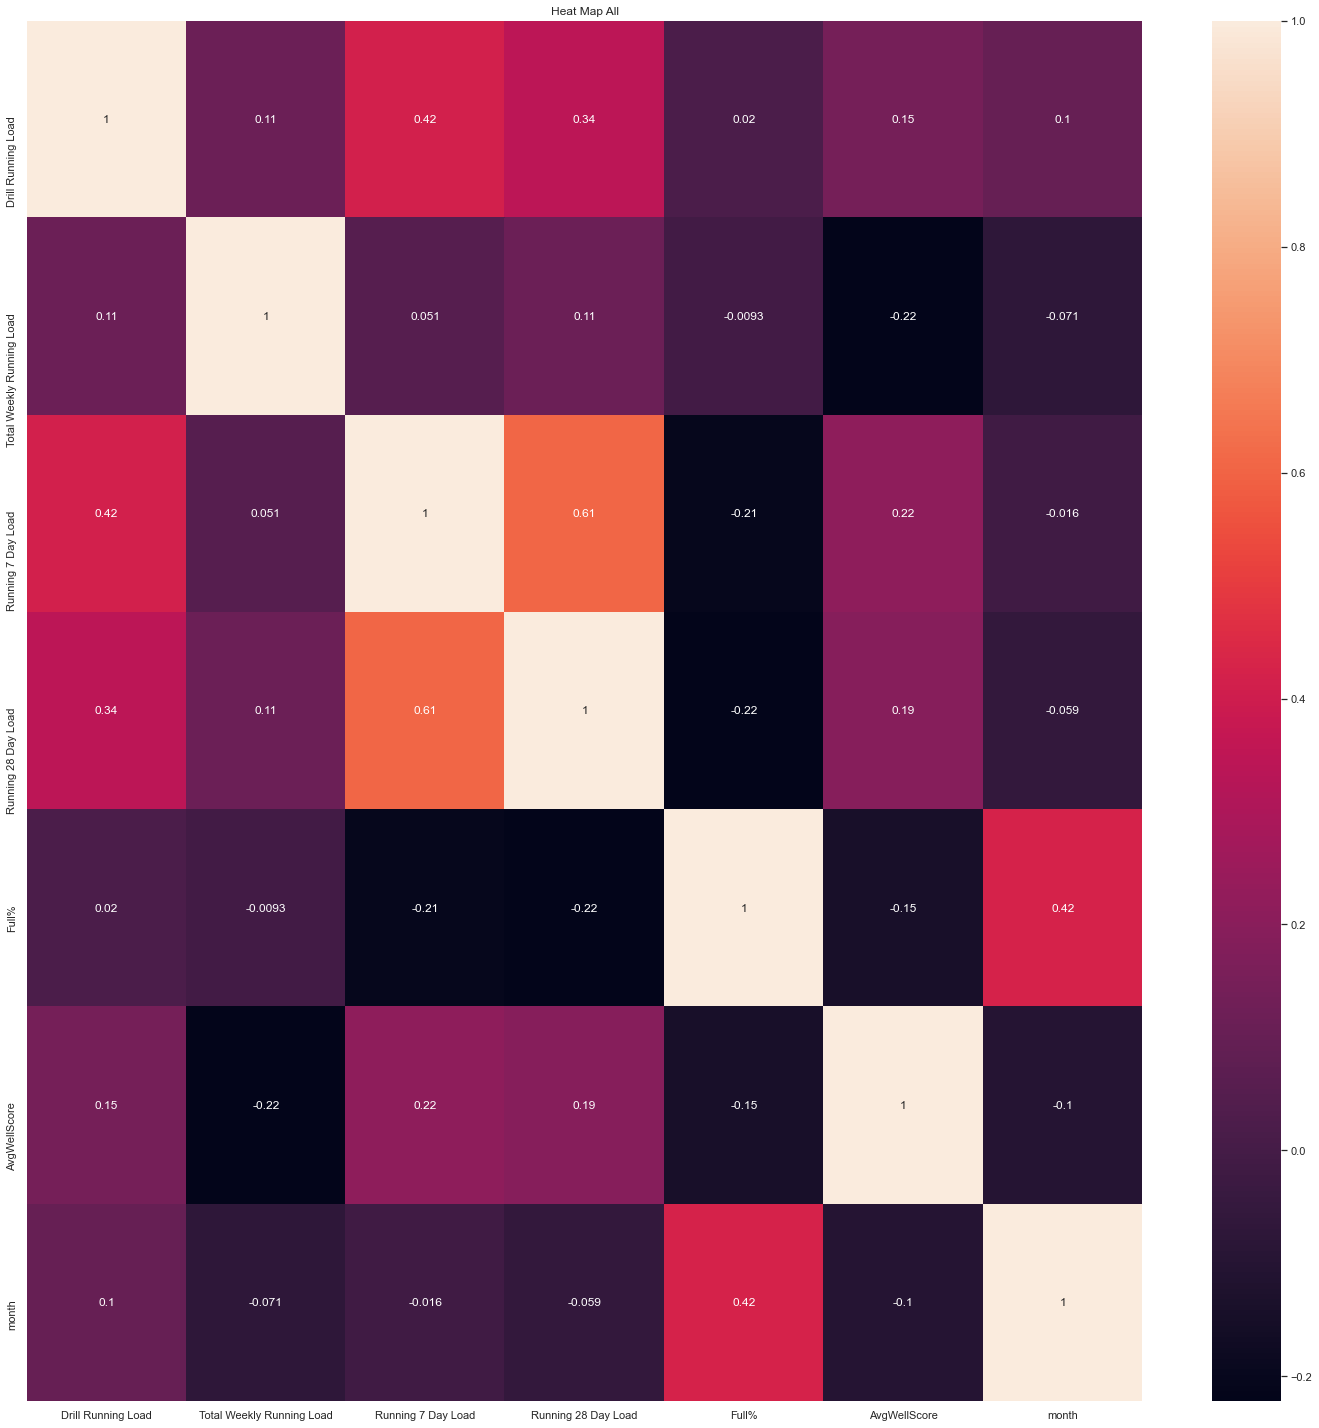

In [59]:
# view correlation of each dataframe for fun
sns.heatmap(dfall.corr(), annot = True)
sns.set(rc = {"figure.figsize":(10,10)})
plt.title('Heat Map All')
plt.show()

In [64]:
# check to see if we need onehotencoding
dfall.dtypes

Drill Running Load           float64
Total Weekly Running Load    float64
Running 7 Day Load           float64
Running 28 Day Load          float64
Full%                        float64
AvgWellScore                 float64
month                          int64
dtype: object

In [65]:
dfall.columns

Index(['Drill Running Load', 'Total Weekly Running Load', 'Running 7 Day Load',
       'Running 28 Day Load', 'Full%', 'AvgWellScore', 'month'],
      dtype='object')

In [66]:
# data splitting
X = dfall.drop(['Full%'], axis = 1)
y = dfall['Full%']
X_trainall, X_testall, y_trainall, y_testall= train_test_split(X, y, test_size = 0.15, random_state = 30)

### Modeling 

####  Random Forest

In [71]:
RF = RandomForestRegressor(max_depth = 2, random_state = 0)

In [72]:
# dfall
RF.fit(X_trainall, y_trainall)
y_pred_all = RF.predict(X_testall)
print('r2 score', r2_score(y_testall, y_pred_all))
print('MSE', mean_squared_error(y_testall, y_pred_all))
print("MAE",mean_absolute_error(y_testall,y_pred_all))

r2 score 0.5790996472538726
MSE 0.00042796469286125255
MAE 0.017786151780153848


#### Gradient Boosting Regressor

In [83]:
GBR = GradientBoostingRegressor()

In [84]:
GBR.fit(X_trainall, y_trainall)
y_pred_all = GBR.predict(X_testall)
print('r2 score', r2_score(y_testall, y_pred_all))
print('MSE', mean_squared_error(y_testall, y_pred_all))
print("MAE",mean_absolute_error(y_testall,y_pred_all))

r2 score 0.4797236761746627
MSE 0.0005290085781020783
MAE 0.018423782758097015


#### Decision Tree Regressor

In [89]:
DTR = DecisionTreeRegressor()

In [90]:
# dfall
DTR.fit(X_trainall, y_trainall)
y_pred_all = DTR.predict(X_testall)
print('r2 score', r2_score(y_testall, y_pred_all))
print('MSE', mean_squared_error(y_testall, y_pred_all))
print("MAE",mean_absolute_error(y_testall,y_pred_all))

r2 score -0.2632048960151665
MSE 0.001284406372712253
MAE 0.019652866988810507


#### Linear Regression 

In [95]:
LR = LinearRegression()

In [96]:
LR.fit(X_trainall, y_trainall)
y_pred_all = LR.predict(X_testall)
print('r2 score', r2_score(y_testall, y_pred_all))
print('MSE', mean_squared_error(y_testall, y_pred_all))
print("MAE",mean_absolute_error(y_testall,y_pred_all))

r2 score 0.3192593671492797
MSE 0.0006921661004923302
MAE 0.023249290979980818


#### Support Vector Regression 

In [101]:
svr = SVR()

In [102]:
svr.fit(X_trainall, y_trainall)
y_pred_all = svr.predict(X_testall)
print('r2 score', r2_score(y_testall, y_pred_all))
print('MSE', mean_squared_error(y_testall, y_pred_all))
print("MAE",mean_absolute_error(y_testall,y_pred_all))

r2 score -0.8009266207527665
MSE 0.0018311531532048653
MAE 0.036847405355985165


### Gradient Boosting Model Optimization

In [110]:
# dfall
GBR.fit(X_trainall, y_trainall)
y_pred_all = GBR.predict(X_testall)

#### Randomized Search CV

In [111]:
parameters = {'learning_rate': sp_randFloat(), 'subsample': sp_randFloat(), 'n_estimators': sp_randInt(100,1000),
             'max_depth': sp_randInt(4,10)}

random = RandomizedSearchCV(estimator=GBR, param_distributions = parameters, cv = 2, n_iter = 10, n_jobs = -1)
random.fit(X_trainall, y_trainall)

# best estimators
random.best_estimator_


GradientBoostingRegressor(learning_rate=0.36028584114209183, max_depth=5,
                          n_estimators=138, subsample=0.793574557475448)

In [112]:
# best score
random.best_score_

-0.009968785165207772

In [113]:
# best parameters
random.best_params_

{'learning_rate': 0.36028584114209183,
 'max_depth': 5,
 'n_estimators': 138,
 'subsample': 0.793574557475448}

#### Grid Search CV

In [114]:
parameters = {'learning_rate': [0.01, 0.02, 0.03, 0.04], 'subsample': [0.9,0.5,0.2, 0.01], 'n_estimators': [100,500,1000, 1500],
             'max_depth': [4,6,8, 10]}

grid = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs = -1)
grid.fit(X_trainall, y_trainall)


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 500, 1000, 1500],
                         'subsample': [0.9, 0.5, 0.2, 0.01]})

In [115]:
# best estimator
grid.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, subsample=0.5)

In [116]:
# best score
grid.best_score_

0.10722035563622995

In [117]:
# best parameters
grid.best_params_

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.5}

In [118]:
# optmize model
# dfall
GBR = GradientBoostingRegressor(learning_rate=0.02, max_depth=8, n_estimators=500,
                          subsample=0.2)
GBR.fit(X_trainall, y_trainall)
y_pred_all = GBR.predict(X_testall)

In [119]:
print('r2 score', r2_score(y_testall, y_pred_all))
print('MSE', mean_squared_error(y_testall, y_pred_all))
print("MAE",mean_absolute_error(y_testall,y_pred_all))

r2 score 0.4843253356931738
MSE 0.000524329684892218
MAE 0.017777319195332902
